In [1]:
import pandas as pd
import numpy as np
import pynndescent
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
employees = pd.read_parquet('employees.parquet')
orcs = pd.read_parquet('orcs.parquet')

Сначала обработаем данные (подробное описание обработки в docstring функции `encode()`)

In [3]:
def encode(row):
    ''' 
    Принимает на вход строчку из датасета в формате массива numpy
    
    Обрабатывает данные, выдавая вектор размерности 130
    0:98 -- имя, фамилия и отчество
    99 -- пол
    100:108 -- дата рождения
    108:120 -- инн
    120:130 -- паспорт

    Имя кодируется вектором `v[0:33]`, где `v[i]` -- количество
    i-ой буквы русского алфавита в имени; фамилия и отчество
    кодируются аналогично
    Если имя NAN, то вектор заполняется нулями

    Пол кодируется следующим образом: 'ж' -> 1, 'м' -> 0

    ИНН кодируется посимвольно (т.е. номер `123` перейдёт в вектор `[1.0, 2.0, 3.0]`); 
    аналогично кодируется дата рождения (из даты предварительно удаляются дефисы) и номер паспорта
    Если ИНН NAN, то вектор заполняется -1
    '''
    code = np.zeros(130)

    def encode_name(name, start_index):
        if not pd.isna(name):
            for s in name:
                if ord(s) >= ord('а') and ord(s) <= ord('я'):
                    code[start_index + ord(s) - ord('а')] += 1    

    encode_name(row[0], 0)
    encode_name(row[1], 33)
    encode_name(row[2], 66)

    if row[3] == 'ж':
        code[99] = 1

    if pd.isna(row[4]):
        code[100:108] = -1.0
    else:
        tmp_str = row[4].replace('-', '')
        for i in range(len(tmp_str)):
            code[100 + i] = float(tmp_str[i])

    if pd.isna(row[5]):
        code[108:120] = -1.0
    else:
        for i in range(len(row[5])):
            code[108 + i] = float(row[5][i])

    if pd.isna(row[6]):
        code[120:130] = -1.0
    else:
        for i in range(len(row[6])):
            code[120 + i] = float(row[6][i])

    return code   

В следующей ячейке реализована моя метрика для данной задачи. Пройдём по порядку:
* Между векторами закодированных ФИО вычисляется косинусное расстояние `name_cosine`;
* Расстояние `gender_diff` между гендерами -- 1, если гендеры совпадают, и 0 в противном случае;
* Между датами рождения, номерами ИНН и паспорта считается нормированная метрика Хэмминга (`birthdate_hamming, inn_hamming, passport_hamming` соответственно); если один из операндов является пропуском в данных, то метрика в таком случае равна 0;
* В итоге выбирается максимум из `name_cosine`, `0.25 * inn_hamming`, `0.25 * passport_hamming`, `0.2 * birthdate_hamming` и `gender_diff`. Как показала практика, если `name_cosine < 0.05`, то имена людей достаточно близки. Соответственно, нужно сделать так, чтобы незначительные опечатки в ИНН или паспорте не перебивали маленькую метрику `name_cosine`, поэтому выбраны коэффициенты `0.25` и `0.2`. В условии задания сказано, что в поле `gender` нет опечаток, поэтому расхождение по гендеру должно сильно наказываться (значение метрики 1 делает так, что такой кандидат на соседа точно не может быть ближайшим).

In [4]:
from numba import njit 

@njit(fastmath=True)
def my_metric(vec1, vec2):
    name1, name2 = vec1[0:99], vec2[0:99]
    gender1, gender2 = vec1[99], vec2[99]
    birthdate1, birthdate2 = vec1[100:108], vec2[100:108]
    inn1, inn2 = vec1[108:120], vec2[108:120]
    passport1, passport2 = vec1[120:130], vec2[120:130]

    # подсчет косинусной метрики взят из pynndescent
    name_cosine = 0.0
    norm_1 = 0.0
    norm_2 = 0.0
    for i in range(name1.shape[0]):
        name_cosine += name1[i] * name2[i]
        norm_1 += name1[i] ** 2
        norm_2 += name2[i] ** 2

    if norm_1 == 0.0 and norm_2 == 0.0:
        name_cosine = 0.0
    elif norm_1 == 0.0 or norm_2 == 0.0:
        name_cosine = 1.0
    else:
        name_cosine = 1.0 - (name_cosine / np.sqrt(norm_1 * norm_2))
        
    # если гендеры совпадают, то gender_diff = 0
    # иначе gender_diff = 1
    gender_diff = np.abs(gender1 - gender2)

    def hamming_nan(x, y):
        '''
        Считаем нормированную метрику Хэмминга
        Если один из векторов NAN (т.е. закодирован -1.0),
        то полагаем, что расстояние Хэмминга равно нулю
        '''
        hamming = 0
        if not (np.allclose(x, -1.0) or np.allclose(y, -1.0)):
            for i in range(x.shape[0]):
                if x[i] != y[i]:
                    hamming += 1
            hamming /= x.shape[0]
        return hamming

    birthdate_hamming = hamming_nan(birthdate1, birthdate2)
    inn_hamming = hamming_nan(inn1, inn2)
    passport_hamming = hamming_nan(passport1, passport2)

    return max(name_cosine, 0.25 * inn_hamming, 0.25 * passport_hamming, gender_diff, 0.2 * birthdate_hamming)

Индекс для решения данной задачи я решил взять из библиотеки `PyNNDescent`, поскольку он поддерживает кастомные метрики на числовых векторах. 

In [5]:
numpy_employees = employees.to_numpy()
numpy_orcs = orcs.to_numpy()

train_data = np.apply_along_axis(arr=numpy_employees, func1d=encode, axis=1)
test_data = np.apply_along_axis(arr=numpy_orcs, func1d=encode, axis=1)

index = pynndescent.NNDescent(train_data, metric=my_metric)
neighbors = index.query(test_data, k=1, epsilon=0.8)

Построим гистограмму расстояний между орками из таблицы и их ближайшими соседями.

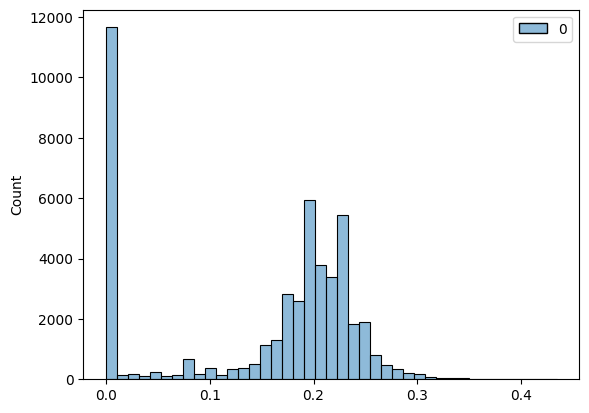

In [6]:
sns.histplot(neighbors[1])
plt.show()

Интуиция подсказывает, что если расстояние от орка до его ближайшего соседа из таблицы работников превышает `0.05`, то между ними скорее всего большая разница, поэтому найденный работник не является орком. В качестве ответа загрузим тех найденных соседей, для которых значение моей метрики `< 0.05`.

In [7]:
real_orcs = neighbors[0][neighbors[1] < 0.05]

res = pd.DataFrame({
    'orig_index': real_orcs.astype(np.uint64),
}).reset_index(names='id')
res.to_parquet('submission.parquet', index=False)

Я пробовал:
* строить индекс из `PyNNDescent` с косинусной метрикой только для преобразованных имён (то есть только на первых 99 компонентах вектора), этот подход и позволил побить бейслайн;
* вместо метрики Хэмминга на кодировке ИНН и номера паспорта использовать евклидову метрику, что не сработало, поскольку разные опечатки наказываются по-разному, что довольно нелогично (метрика должна зависеть от количества опечаток, а не от того, насколько большая разница между цифрами, на которых допущены опечатки);
* ради интереса строить индекс из `nmslib` на исходных именах, используя метрику Левенштейна (что очень долго и плохо работало, поскольку имя в отрыве от остальных данных плохой признак для поиска соседей: есть много людей с одинаковыми именами).